#Final Model

The following notebook is representing the final model for our research project in the field of Nucleus Segmentation. 

For further illustrations of each code chunck please take a closer look into our detailed project documentary in the notebook "NUciSeg Final.ipy".

#Setup

In [1]:
import os
import random
from matplotlib import image
from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 686kB 7.9MB/s 


In [2]:
# Mounting your personal gDrive in order to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
#Load data
local_zip = '/content/drive/MyDrive/Nucleus-main/O_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')

local_zip = '/content/drive/MyDrive/Nucleus-main/IG_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')

local_zip = '/content/drive/MyDrive/Nucleus-main/IG_data_new.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')

#Load model
local_zip = '/content/drive/MyDrive/Nucleus-main/U-Net_model_SigmoidFocalCrossEntropy_IG_A.h5.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/Model')

#Image Genenrator 

In [4]:
batch_size = 32
image_size = 256

data_gen_args = dict(rescale= 1/255,
                     horizontal_flip=True,
                     vertical_flip=True,
                     #rotation_range=90,
                     #width_shift_range=0.1,
                     #height_shift_range=0.1,
                     #zoom_range=0.2,
                     fill_mode = 'constant')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_generator = image_datagen.flow_from_directory(
    '/tmp/IG_data_new/train_raw',
    batch_size = batch_size,
    class_mode=None,
    target_size = (image_size, image_size),
    color_mode="grayscale",
    seed=seed)
mask_generator = mask_datagen.flow_from_directory(
    '/tmp/IG_data_new/train_solutions',
    batch_size = batch_size,
    class_mode=None,
    target_size = (image_size, image_size),
    color_mode="grayscale",
    seed=seed)

train_generator = zip(image_generator, mask_generator)
print(type(train_generator))

Found 555 images belonging to 1 classes.
Found 555 images belonging to 1 classes.
<class 'zip'>


(32, 256, 256, 1)


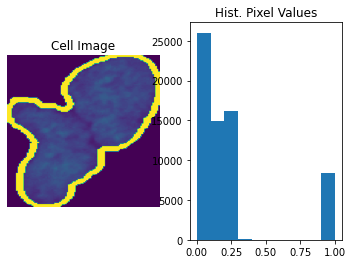

(32, 256, 256, 1)


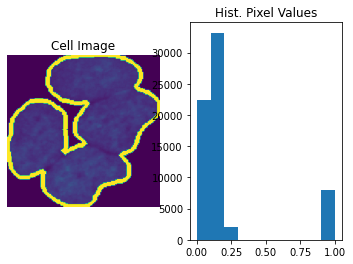

(32, 256, 256, 1)


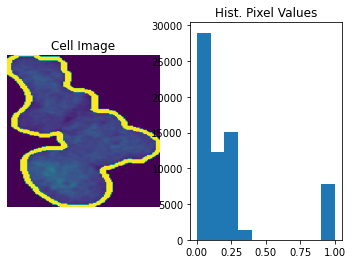

In [ ]:
for i in range(3):
    img = image_generator.next()    
    im = np.squeeze(img[0])
    tt = im.flatten()

    #(BachtSize, Image Size, Channels)
    print(img.shape)
    plt.subplot(1,2,1), 
    plt.imshow(im)
    plt.title('Cell Image'), plt.axis('off')
    plt.subplot(1,2,2)
    plt.hist(tt)
    plt.title('Hist. Pixel Values')
    plt.show()

(32, 256, 256, 1)


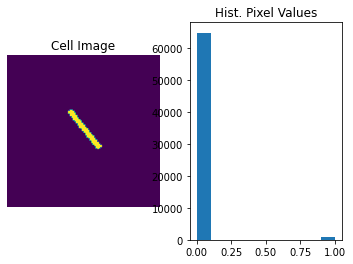

(32, 256, 256, 1)


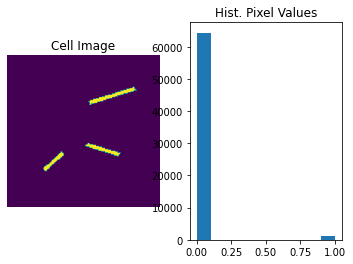

(32, 256, 256, 1)


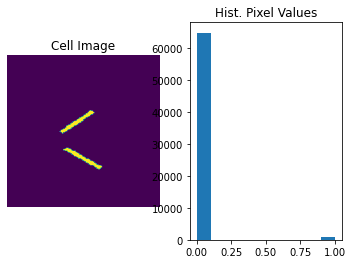

In [ ]:
for i in range(3):
    img = mask_generator.next()    
    im = np.squeeze(img[0])
    tt = im.flatten()

   #(BachtSize, Image Size, Channels)
    print(img.shape)
    plt.subplot(1,2,1), 
    plt.imshow(im)
    plt.title('Cell Image'), plt.axis('off')
    plt.subplot(1,2,2)
    plt.hist(tt)
    plt.title('Hist. Pixel Values')
    plt.show()

In [5]:
# Image_Generator for validation
batch_size_val = 1
image_size = 256

image_datagen_val = ImageDataGenerator(rescale= 1/255)
mask_datagen_val = ImageDataGenerator(rescale= 1/255)

seed_val = 2
image_generator_val = image_datagen_val.flow_from_directory(
    '/tmp/IG_data_new/test_raw',
    batch_size = batch_size_val,
    class_mode=None,
    target_size = (image_size, image_size),
    color_mode="grayscale",
    seed=seed_val)
mask_generator_val = mask_datagen_val.flow_from_directory(
    '/tmp/IG_data_new/test_solutions',
    batch_size = batch_size_val,
    class_mode=None,
    target_size = (image_size, image_size),
    color_mode="grayscale",
    seed=seed_val)
val_generator = zip(image_generator_val, mask_generator_val)
print(type(val_generator))

Found 42 images belonging to 1 classes.
Found 42 images belonging to 1 classes.
<class 'zip'>


<function matplotlib.pyplot.show>

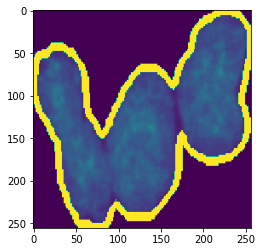

In [6]:
validation_matrix_IG = np.zeros((42, image_size, image_size, 1))
for i in range(42):
    img = image_generator_val.next()
    img = np.squeeze(img[0])
    validation_matrix_IG[i,:,:,0] = img  

plt.imshow(validation_matrix_IG[4,:,:,0])
plt.show

<function matplotlib.pyplot.show>

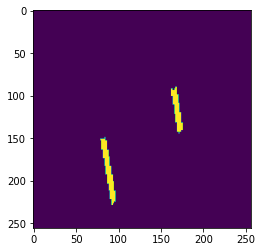

In [7]:
validation_matrix_GT_IG = np.zeros((42, image_size, image_size, 1))
for i in range(42):
    img = mask_generator_val.next()
    img = np.squeeze(img[0])
    validation_matrix_GT_IG[i,:,:,0] = img    
plt.imshow(validation_matrix_GT_IG[4,:,:,0])
plt.show

#U-Net

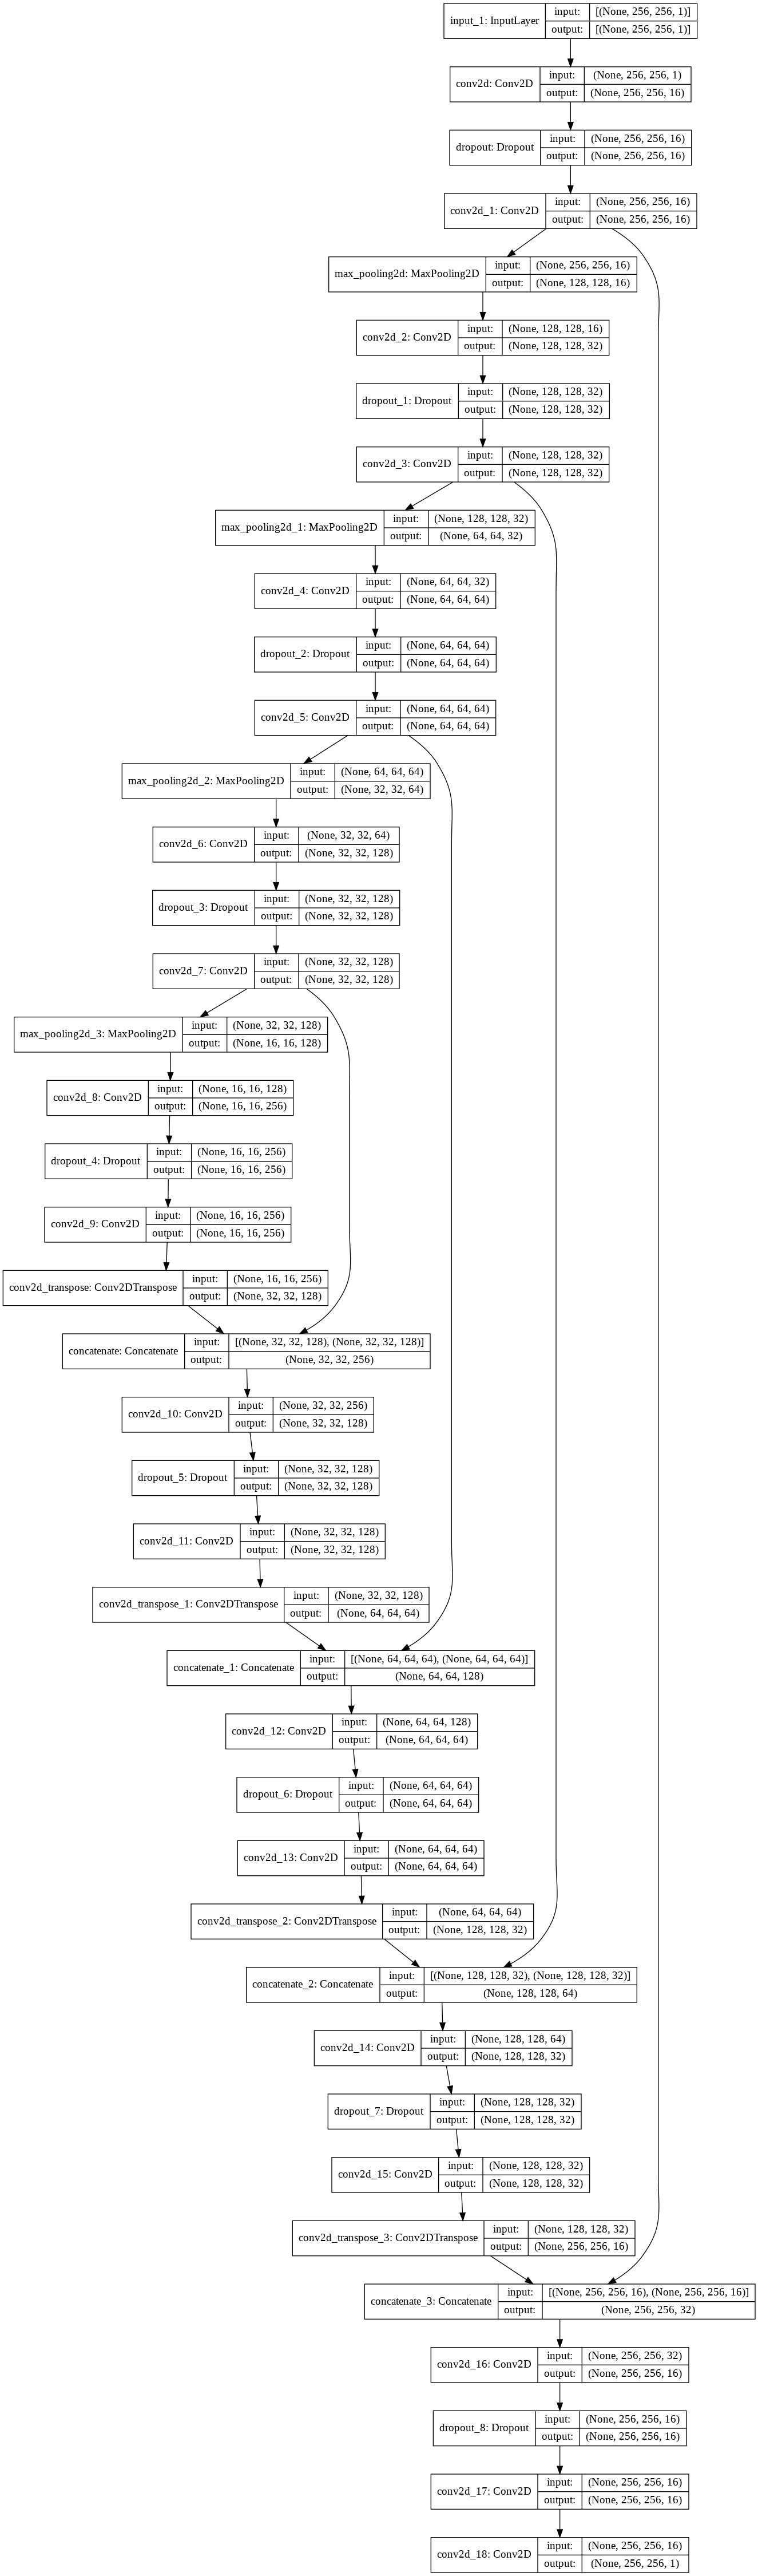

In [8]:
inputs = tf.keras.layers.Input((256, 256,1))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

tf.random.set_seed(0)
u_net_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

tf.keras.utils.plot_model(u_net_model, show_shapes = True)

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 0.0023 - f1_score: 0.0296

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


17/17 [==============================] - 6s 299ms/step - loss: 0.0023 - f1_score: 0.0296 - val_loss: 0.0017 - val_f1_score: 0.0296

Epoch 00001: val_loss improved from inf to 0.00172, saving model to /tmp/U-Net_model_SigmoidFocalCrossEntropy_IG_A.h5
Epoch 2/100
17/17 [==============================] - 5s 287ms/step - loss: 0.0017 - f1_score: 0.0453 - val_loss: 0.0015 - val_f1_score: 0.1913

Epoch 00002: val_loss improved from 0.00172 to 0.00149, saving model to /tmp/U-Net_model_SigmoidFocalCrossEntropy_IG_A.h5
Epoch 3/100
17/17 [==============================] - 5s 285ms/step - loss: 0.0015 - f1_score: 0.2103 - val_loss: 0.0016 - val_f1_score: 0.4775

Epoch 00003: val_loss did not improve from 0.00149
Epoch 4/100
17/17 [==============================] - 5s 282ms/step - loss: 0.0015 - f1_score: 0.4072 - val_loss: 0.0017 - val_f1_score: 0.6121

Epoch 00004: val_loss did not improve from 0.00149
Epoch 5/100
17/17 [==============================] - 5s 293ms/step - loss: 0.0015 - f1_score: 

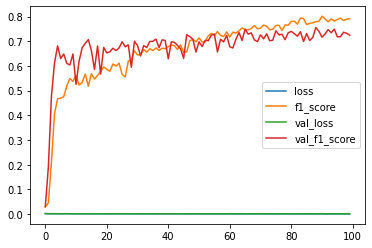

In [13]:
#u_net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
u_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tfa.losses.SigmoidFocalCrossEntropy(), metrics=[tfa.metrics.F1Score(num_classes=1, average='micro', threshold=0.5)])


# Define callbacks
callbacks = [
        tf.keras.callbacks.ModelCheckpoint('/tmp/U-Net_model_SigmoidFocalCrossEntropy_IG_A.h5', verbose=1, save_best_only=True),     
        #tf.keras.callbacks.EarlyStopping(patience=10, monitor='loss'),
        #tf.keras.callbacks.TensorBoard(log_dir='logs')
       ]

# Fit the model
u_net_model.fit(train_generator, validation_data = (validation_matrix_IG, validation_matrix_GT_IG), epochs = 100, verbose =1, steps_per_epoch= 555 // batch_size, callbacks = callbacks)

# check out the metrics...
performance = pd.DataFrame(u_net_model.history.history)
performance.plot()

##Predictions

In [14]:
u_net_model = keras.models.load_model('/tmp/Model/U-Net_model_SigmoidFocalCrossEntropy_IG_A.h5')

print("Evaluate the Image Generator in the case of the U-Net")
results = u_net_model.evaluate(validation_matrix_IG, validation_matrix_GT_IG, batch_size=1)
print("test loss, test f1:", results)

Evaluate the Image Generator in the case of the U-Net


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


42/42 [==============================] - 1s 4ms/step - loss: 0.0017 - f1_score: 0.7703
test loss, test f1: [0.00165137043222785, 0.7702579498291016]


In [10]:
train_matrix = np.load("/tmp/O_data/train_matrix_256.npy")
train_matrix_ground_truth = np.load("/tmp/O_data/train_matrix_ground_truth_256.npy")
valid_matrix = np.load("/tmp/O_data/valid_matrix_256.npy")
valid_matrix_ground_truth = np.load("/tmp/O_data/valid_matrix_ground_truth_256.npy")

max_row = 256
max_colum = 256

#Inc. of a helper function to visualize the prediction
def plot_some_data(plot_number, number_of_columns, input_matrix, ground_truth_matrix, prediction_matrix):
    """Its the same as the previous function ("plot_some_data") just extanded with the predictions
    from the model and without paths instead the big matrixs

    Parameters:
    -----------
    plot_number:int
      Number of plots you want to make.
    number_of_columns:int
      Number of columns in the figure.
    input_matrix:np.array
      Numpy array with the input data
    ground_truth_matrix:np.array
      Numpy array with the input data
    prediction_matrix:np.array
      Numpy array with the prediction of a model
  
    Returns:
    --------
    Nothing
    """
    space = 0
    figure = plt.figure(figsize=(30,30))
    for i in range(plot_number):
      #picture
      plt.subplot(np.ceil(plot_number/number_of_columns)*3, number_of_columns, i+1+space)
      plt.imshow(input_matrix[i, :, :, 0], aspect="auto")
      plt.title(f"Input picture number {i}")
      #ground truth
      plt.subplot(np.ceil(plot_number/number_of_columns)*3, number_of_columns, i+number_of_columns+1+space)
      plt.imshow(ground_truth_matrix[i, :, :, 0], aspect="auto")
      plt.title(f"Groud truth number {i}")
      #prediction
      plt.subplot(np.ceil(plot_number/number_of_columns)*3, number_of_columns, i+number_of_columns*2+1+space)
      plt.imshow(prediction_matrix[i, :, :, 0], aspect="auto")
      plt.title(f"model prediction number {i}")
      if ((i+1)%number_of_columns)==0:
        space += number_of_columns*2
    # plt.imshow(figure)

def predict_values(input_matrix, ground_truth, model):
  """This function let the model predict and plots the input, ground truth and
  prediction in a subplot.

  Parameters:
  -----------
  input_matrix:np.array
    Numpy array with the input data
  ground_truth_matrix:np.array
    Numpy array with the input data
  model:Tensorflow model
    A tensorflow model
  
  Returns:
  --------
  Nothing
  """

  prediction = model.predict(input_matrix)
  plot_some_data(input_matrix.shape[0], 5, input_matrix, ground_truth, prediction)


number_of_pic = 10
random_number = np.random.randint(train_matrix.shape[0]-number_of_pic)

**Trainings Data**

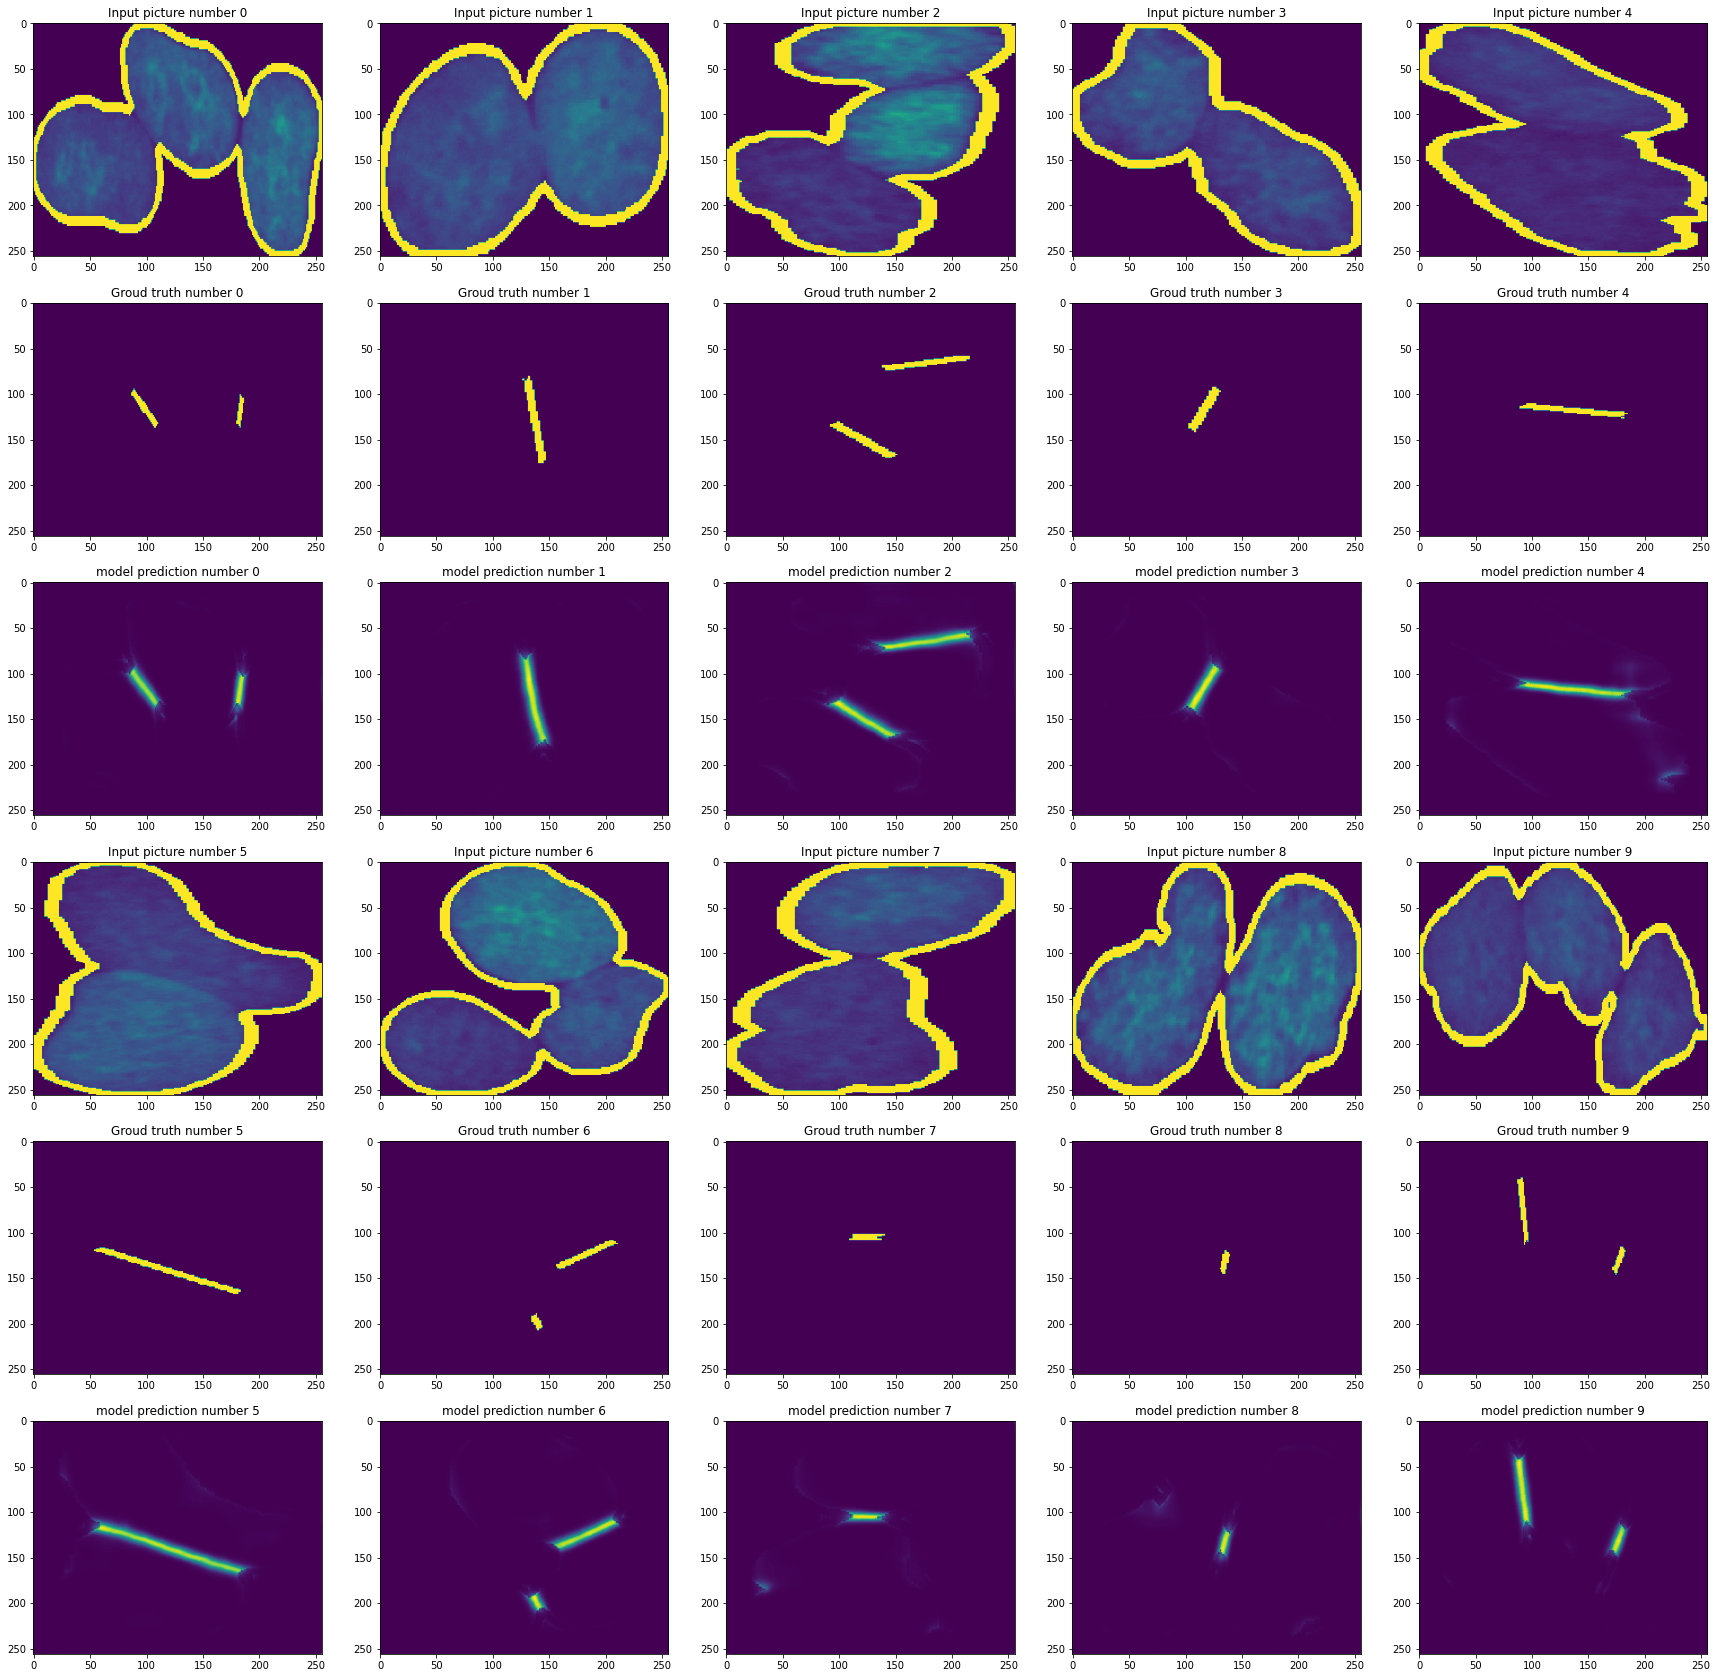

In [ ]:
number_of_pic = 10
img_raw = image_generator.next()
img_mask = mask_generator.next()
random_number = np.random.randint(img_raw.shape[0]-number_of_pic)
predict_values(img_raw[random_number:random_number+number_of_pic], img_mask[random_number:random_number+number_of_pic], u_net_model)

**Validation Data**

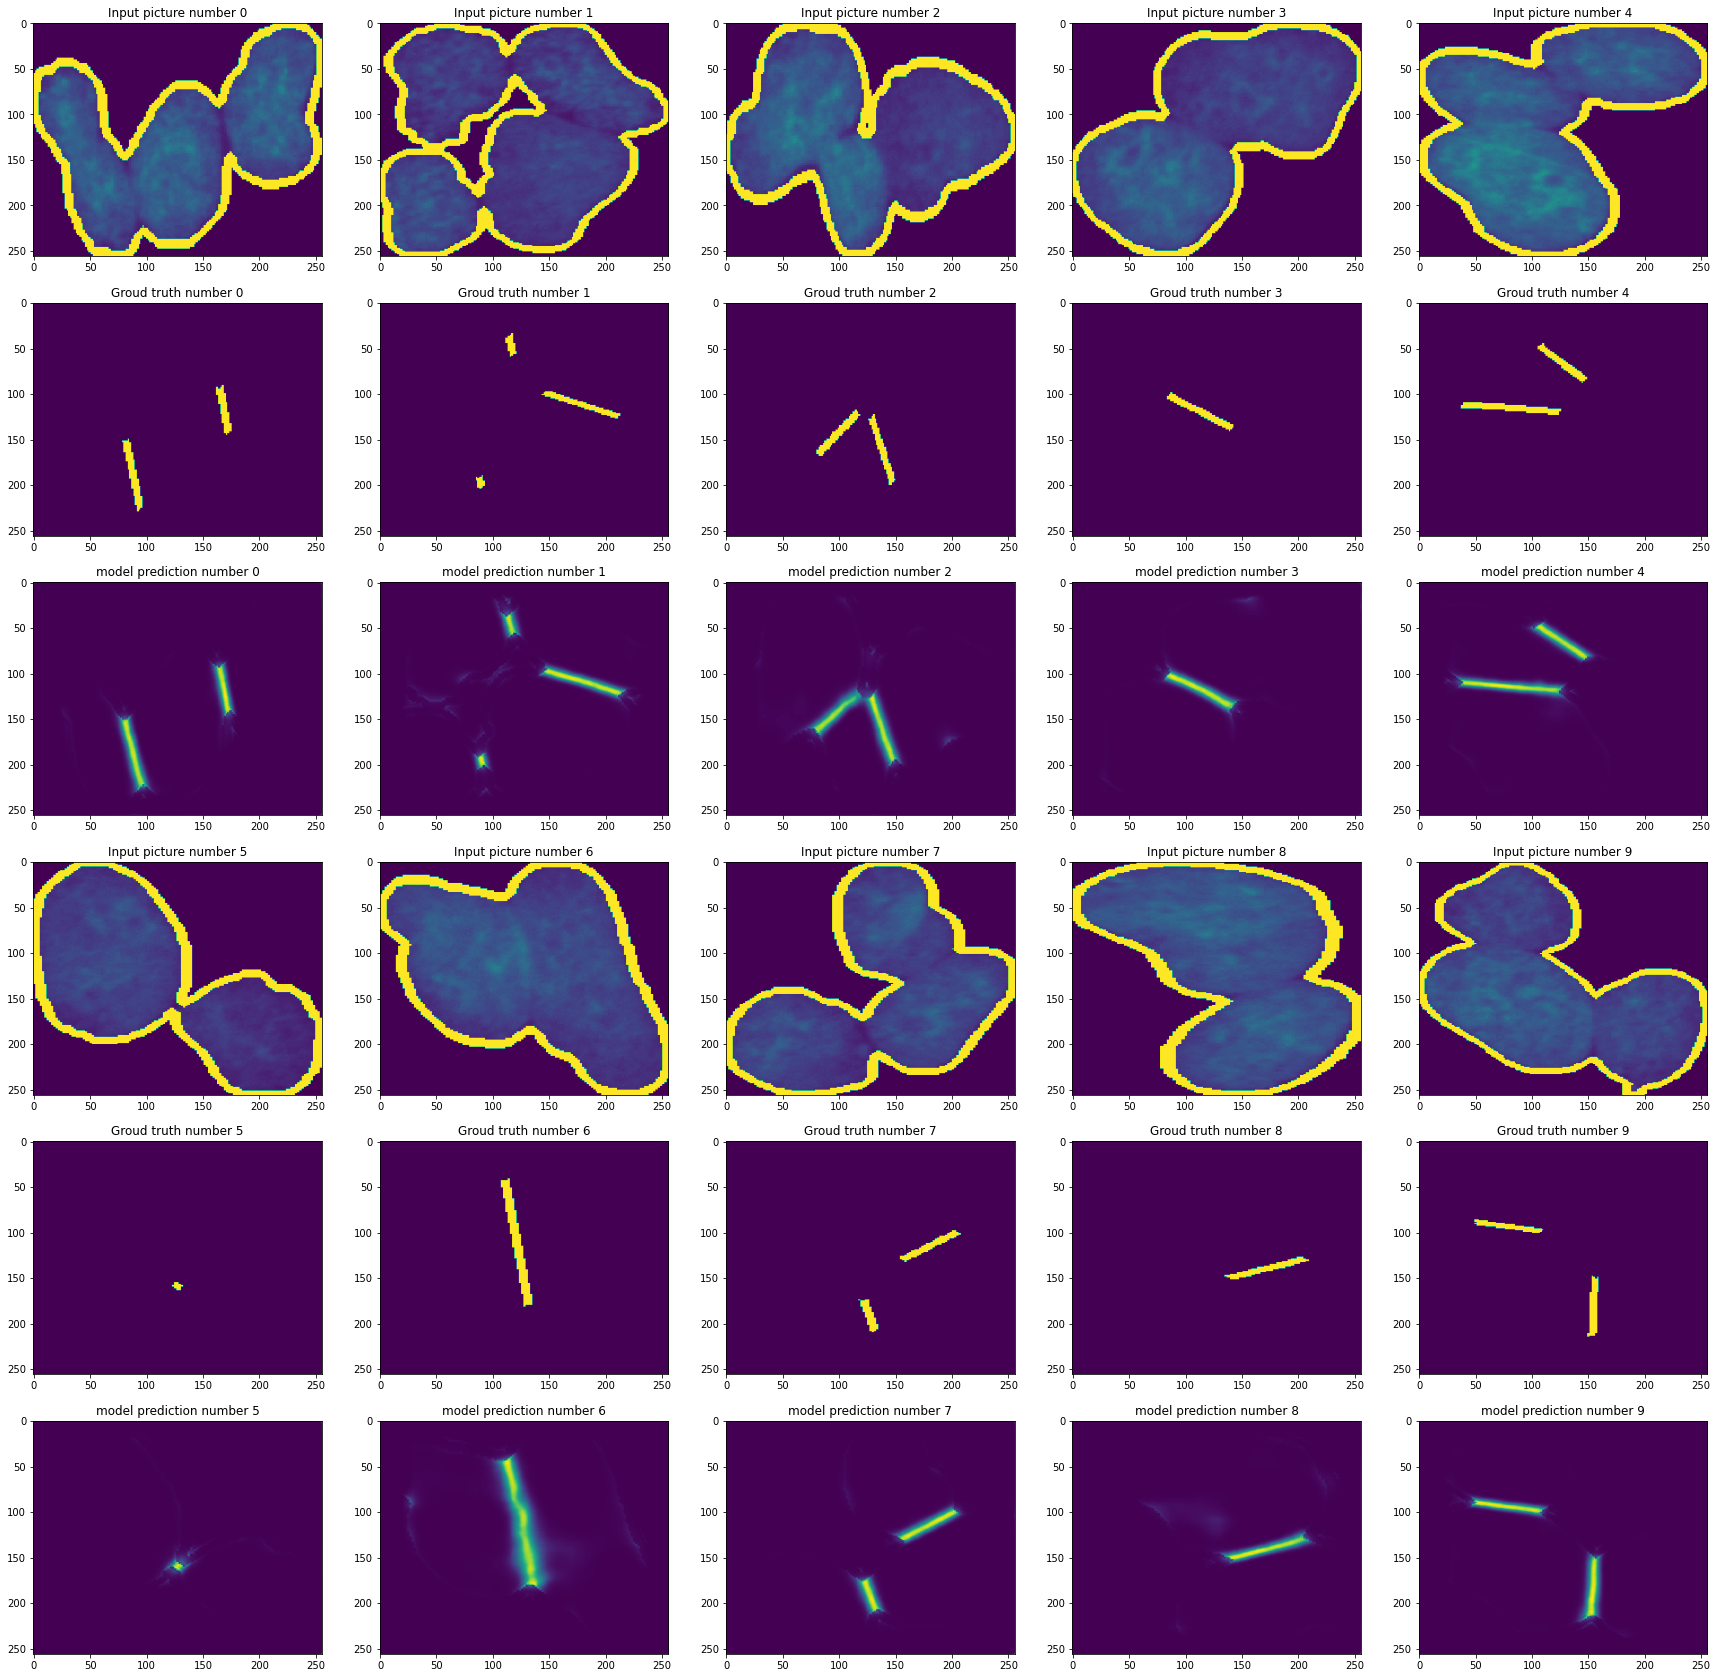

In [ ]:
number_of_pic = 10
img_raw = validation_matrix_IG 
img_mask = validation_matrix_GT_IG
random_number = np.random.randint(img_raw.shape[0]-number_of_pic)
predict_values(img_raw[random_number:random_number+number_of_pic], img_mask[random_number:random_number+number_of_pic], u_net_model)